# Load Preprocessed Data

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt

from config import RAW_DIR, PRE_DIR, RES_DIR
from utils.data_porter import read_from_csv, save_to_csv

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [3]:
with open(os.path.join(PRE_DIR, 'train_data.pkl'), 'rb') as f:
    train_data = pickle.load(f)
train_data.head()

with open(os.path.join(PRE_DIR, 'test_data.pkl'), 'rb') as f:
    test_data = pickle.load(f)
test_data.head()

,overall,asin,reviewTime,reviewerID,reviewerName,reviewText,summary,num_review_ps,num_review_gm
0,5.0,B0000296O5,1999-10-14,A2AXQTB83VMK4L,Amazon Customer,I'm having the most fun I've ever had on PlayS...,Best RPG Ever!,6,268
1,4.0,B00002NDRY,1999-11-05,A2T04VAIXSKJH2,Stefan,I'm usually not crazy about real-time strategy...,Good real time strategy game,6,67
2,5.0,B000021Y5F,1999-11-10,A1QA8K3LD9K892,Chris Adamson,Williams made games for hard-core arcade gamer...,A cool 80's artifact,23,7
3,4.0,B00000JL6V,1999-11-10,AMGJMFJ63DWWH,Ed Matuskey,"Once again you put your hand to the book, and ...","Beautiful game, with excellent (and hard!) puz...",5,37
4,5.0,B00000K4AX,1999-11-10,A3VWWQT4XDSBGQ,Joshua W. Fenton,"If you loved Half-Life, this is a must buy. I ...",AWESOME!,5,26


,overall,asin,reviewTime,reviewerID,reviewerName,reviewText,summary,num_review_ps,num_review_gm
424371,3.0,B00L59D9HG,2017-01-16,A1JO2IPCY1J4PS,Honest Frizz,No problem at all with the charger itself. It...,You have to buy it Separately,5,390
424372,5.0,B00005ATSN,2017-01-16,ANVJU2ROVJC8A,Jemi Linked,Great game!,LOZ forever!,9,38
424373,5.0,B015OYM10I,2017-01-16,A19K4H7U79QKE0,Rafael Quintero,Awesome!,Five Stars,11,45
424374,5.0,B00Y4S5KPY,2017-01-16,A11JVJHDF59HJC,Hammerton,Son loves it and works with other razer color ...,Five Stars,7,119
424375,1.0,B00O4FOB3O,2017-01-16,A1JXGU255ZN7JJ,MasterBlaster,I'm updating my review after having used these...,great to start but...,8,31


# NLP Processing

In [4]:
import re
# Use nltk for text processing
# Note: the original corpus of nltk is no longer available for download and needs to be manually added locally
import nltk
# nltk.download('stopwords')
# manually add
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
english_stemmer=nltk.stem.SnowballStemmer('english')

In [5]:
def data_clean(rev, remove_stopwords=True): 
    try:
        # only retain English characters
        new_text = re.sub("[^a-zA-Z]"," ", rev)
    except:
        print(rev)
        new_text = []
   # Lowercase all letters and split words
    words = new_text.lower().split()
    
    if remove_stopwords:
        sts = set(stopwords.words("english"))
        words = [w for w in words if not w in sts]
    ary=[]
    eng_stemmer = english_stemmer 
    for word in words:
        ary.append(eng_stemmer.stem(word))

    new_ary = ' '.join(ary)
    return(new_ary)

In [6]:
# Define multi-threaded data processing functions

def generate_tasks(data, process_num):
    num = data.shape[0]
    tasks = []
    for i in range(process_num):
        tasks.append((data[int(i*num/process_num): int((i+1)*num/process_num)],))
    return tasks

SIA = SentimentIntensityAnalyzer()
def split_and_emo(data, emo_type_lst=['pos', 'neg'], sia=SIA):
    data['docs'] = data.apply(lambda x: data_clean(x.reviewText) + data_clean(x.summary), axis=1)
    for emo_type in emo_type_lst:
        data[emo_type] = data['docs'].apply(lambda x: sia.polarity_scores(x)[emo_type])
    return data

def npl_for_multi(args):
    res = split_and_emo(*args)
    res = res.reset_index(drop=True)
    return res

In [7]:
# Users who did not comment a review are filled with ''
train_data = train_data.fillna('')

In [8]:
# import time

# sample = train_data.iloc[: 5000]

# start = time.time()
# sample['docs'] = sample.apply(lambda x: data_clean(x.reviewText) + data_clean(x.summary), axis=1)
# sample['pos'] = sample['docs'].apply(lambda x: SIA.polarity_scores(x)['pos'])
# elapsed = (time.time() - start)
# print("Time used:",elapsed)

# start = time.time()
# process_num = 7
# tasks = generate_tasks(sample, process_num)
# with ProcessPoolExecutor(max_workers=process_num) as excutor:
#     mul_data = excutor.map(npl_for_multi, tasks)
# elapsed = (time.time() - start)
# print("Time used:",elapsed)

In [9]:
process_num = 7
tasks = generate_tasks(train_data, process_num)
with ProcessPoolExecutor(max_workers=process_num) as excutor:
    mul_data = excutor.map(npl_for_multi, tasks)
nlp_data = pd.concat(mul_data)
nlp_data.head()

,overall,asin,reviewTime,reviewerID,reviewerName,reviewText,summary,num_review_ps,num_review_gm,docs,pos,neg
0,5.0,B0000296O5,1999-10-14,A2AXQTB83VMK4L,Amazon Customer,I'm having the most fun I've ever had on PlayS...,Best RPG Ever!,6,268,fun ever playstat high recommend best rpg ever...,0.588,0.000
1,4.0,B00002NDRY,1999-11-05,A2T04VAIXSKJH2,Stefan,I'm usually not crazy about real-time strategy...,Good real time strategy game,6,67,usual crazi real time strategi game tend becom...,0.306,0.000
2,5.0,B000021Y5F,1999-11-10,A1QA8K3LD9K892,Chris Adamson,Williams made games for hard-core arcade gamer...,A cool 80's artifact,23,7,william made game hard core arcad gamer collec...,0.181,0.102
3,4.0,B00000JL6V,1999-11-10,AMGJMFJ63DWWH,Ed Matuskey,"Once again you put your hand to the book, and ...","Beautiful game, with excellent (and hard!) puz...",5,37,put hand book enter anoth world time riven eff...,0.347,0.031
4,5.0,B00000K4AX,1999-11-10,A3VWWQT4XDSBGQ,Joshua W. Fenton,"If you loved Half-Life, this is a must buy. I ...",AWESOME!,5,26,love half life must buy big fpshooter fan ss l...,0.388,0.060


In [10]:
nlp_data['pos'].max()
nlp_data['pos'].min()
nlp_data['pos'].mean()

1.0

0.0

0.2752716490994908

In [11]:
nlp_data['neg'].max()
nlp_data['neg'].min()
nlp_data['neg'].mean()

0.935

0.0

0.06115133456338911

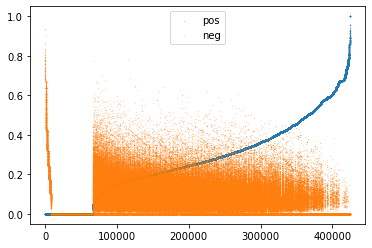

In [12]:
# Overview of the distribution of user sentiment ratings

nlp_data = nlp_data.sort_values(by=['pos', 'neg'], ascending=[True, False])
plt.scatter(range(nlp_data.shape[0]), nlp_data['pos'], s=0.01, label='pos')
plt.scatter(range(nlp_data.shape[0]), nlp_data['neg'], s=0.01, label='neg')
plt.legend()

## Positive Correction

In [22]:
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import BaselineOnly, KNNBaseline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

In [14]:
def print_metrics_sp(predictions):
    mae_score = accuracy.mae(predictions)
    mae_score = accuracy.mse(predictions)
    return mae_score, mae_score

In [15]:
reader = Reader(rating_scale = (0.0, 5.0))
test_rate = test_data[['asin', 'reviewerID', 'overall']]
test_set = Dataset.load_from_df(test_rate, reader).build_full_trainset().build_testset()

In [16]:
nlp_data['overall'] = nlp_data.apply(lambda x: x.overall + x.pos if x.overall < 5 else 5, axis=1)

In [17]:
nlp_train_rate = nlp_data[['asin', 'reviewerID', 'overall']]
nlp_train_set = Dataset.load_from_df(nlp_train_rate, reader).build_full_trainset()

We have selected the optimal parameters and confirmed that the larger the data, the better the model, so here we use the optimal parameters, the 90% data as training set and the same test set as in the Basic_Model to compare the results

In [18]:
bsl_options = {
    'method': 'als',
    'n_factors':200, 
    'n_epochs':30,
    'lr_all':0.005,
    'reg_all':0.1
}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(nlp_train_set)
predictions = bias_baseline.test(test_set)

_, _ = print_metrics_sp(predictions)

Estimating biases using als...


MAE:  0.8202
MSE: 1.2192


In [20]:
# Test set

bias_sgd = SVD(n_factors=10, n_epochs=30, lr_all=0.005, reg_all=0.01)
bias_sgd.fit(nlp_train_set)
predictions = bias_sgd.test(test_set)
_, _ = print_metrics_sp(predictions)

MAE:  0.7934
MSE: 1.2157


In [23]:
# Test set

knn_model = KNNBaseline(k=50, min_k=2)
knn_model.fit(nlp_train_set)
predictions = knn_model.test(test_set)
print_metrics_sp(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


MAE:  0.8128
MSE: 1.2407


(1.240663918345804, 1.240663918345804)

## Negative Correction

In [24]:
nlp_data['overall'] = nlp_data.apply(lambda x: int(x.overall - x.neg) if x.overall < 5 else 5, axis=1)

In [25]:
nlp_train_rate = nlp_data[['asin', 'reviewerID', 'overall']]
nlp_train_set = Dataset.load_from_df(nlp_train_rate, reader).build_full_trainset()

In [26]:
bsl_options = {
    'method': 'als',
    'n_factors':200, 
    'n_epochs':30,
    'lr_all':0.005,
    'reg_all':0.1
}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(nlp_train_set)
predictions = bias_baseline.test(test_set)

_, _ = print_metrics_sp(predictions)

Estimating biases using als...


MAE:  0.8700
MSE: 1.2339


In [27]:
bias_sgd = SVD(n_factors=200, n_epochs=30, lr_all=0.005, reg_all=0.02)
bias_sgd.fit(nlp_train_set)
predictions = bias_sgd.test(test_set)
_, _ = print_metrics_sp(predictions)

MAE:  0.8615
MSE: 1.2595


In [29]:
# Test set

bias_sgd = SVD(n_factors=10, n_epochs=30, lr_all=0.005, reg_all=0.01)
bias_sgd.fit(nlp_train_set)
predictions = bias_sgd.test(test_set)
_, _ = print_metrics_sp(predictions)

MAE:  0.8428
MSE: 1.2407


In [30]:
# Test set

knn_model = KNNBaseline(k=50, min_k=2)
knn_model.fit(nlp_train_set)
predictions = knn_model.test(test_set)
print_metrics_sp(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


MAE:  0.8644
MSE: 1.2778


(1.277796913547825, 1.277796913547825)

## Pos/Neg Correction

In [31]:
def cal_pos_to_neg(overall, pos, neg):
    if overall == 5 or overall == 0:
        return overall
    if pos == 0 or neg == 0:
        return overall
    else:
        return overall * (pos/neg)

In [32]:
nlp_data['overall'] = nlp_data.apply(lambda x: cal_pos_to_neg(x.overall, x.pos, x.neg), axis=1)

In [33]:
nlp_train_rate = nlp_data[['asin', 'reviewerID', 'overall']]
nlp_train_set = Dataset.load_from_df(nlp_train_rate, reader).build_full_trainset()

In [34]:
bsl_options = {
    'method': 'als',
    'n_factors':200, 
    'n_epochs':30,
    'lr_all':0.005,
    'reg_all':0.1
}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(nlp_train_set)
predictions = bias_baseline.test(test_set)

_, _ = print_metrics_sp(predictions)

Estimating biases using als...


MAE:  0.6729
MSE: 1.6875


In [35]:
# Test set

bias_sgd = SVD(n_factors=10, n_epochs=30, lr_all=0.005, reg_all=0.01)
bias_sgd.fit(nlp_train_set)
predictions = bias_sgd.test(test_set)
_, _ = print_metrics_sp(predictions)

MAE:  0.7266
MSE: 1.7863


In [36]:
# Test set

knn_model = KNNBaseline(k=50, min_k=2)
knn_model.fit(nlp_train_set)
predictions = knn_model.test(test_set)
print_metrics_sp(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


MAE:  0.6978
MSE: 1.7144


(1.7143689048971542, 1.7143689048971542)